In [1]:
# This code can be used to load light curve training dataset and do the
# preprocessing like vertical scaling and extending the light curve
# CNN Model is defined
# Training, learning rate scheduler and early stopping feature included

# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d


2024-04-09 16:27:53.515577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 16:27:57.174956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [2]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/train/npy/shape/shape_5.npy'
train_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/train/npy/lc/lc_10_shape_multisize_multiLDC.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
print('train_lc.shape =',train_lc.shape)
print('train_shape.shape = ',train_shape.shape)
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/shape/shape_1.npy'
vald_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/lc/lc_10_shape_multisize_multiLDC.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
print('vald_lc.shape =',vald_lc.shape)
print('vald_shape.shape = ',vald_shape.shape)
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")

# 3. Normalize the lightcurves - vertically
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")




train_lc.shape = (132136, 100)
train_shape.shape =  (132136, 38, 38)
Train Set: No. of LC = No. of shapes
vald_lc.shape = (1000, 100)
vald_shape.shape =  (1000, 38, 38)
Vald Set: No. of LC = No. of shapes
Normalized the shape
Normalized the light curves


In [ ]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 4. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],150))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,25:125] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],150))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,25:125] = vald_lc_scaled[i]
print("Extended the light curves")

<Figure size 640x480 with 0 Axes>

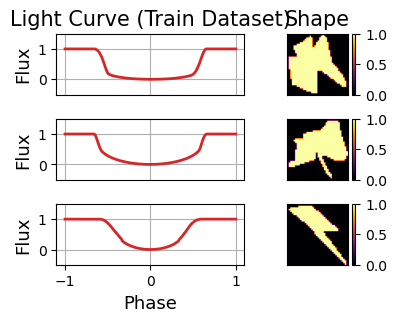

In [15]:
# Verification
# Plot - Train LCs
plt.clf()
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    # ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1
# plt.savefig('/scratch/abraham/Documents/mega_git/mega/ml_model/mar26_2024_model/plot_train_lc.png')
# plt.close()

<Figure size 640x480 with 0 Axes>

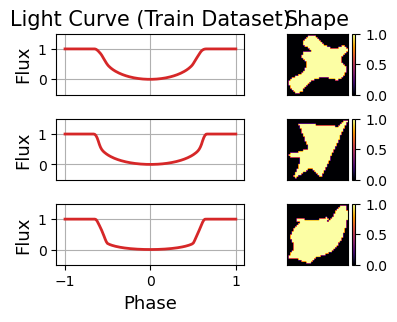

In [16]:
# Verification
# Plot - Vald LCs
plt.clf()
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    # ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [8]:
# Horizontal scaling
def scale_horizontally(input_lc_dataset):
    # lc_np_array_offset_mask used to select the flat part by certain percentage
    input_lc_dataset_mask = np.copy(input_lc_dataset)

    for iteration in np.arange(len(input_lc_dataset)):
        # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

    print("Length of one LC = ", len(input_lc_dataset_mask[0]))

    count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
    for iteration in np.arange(len(input_lc_dataset_mask)):
        # Calculate the number of occurrences of '0'
        count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
        count_zeros_array[iteration] = count_zeros
    
    # Interpolate the light curve
    input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
    len_selected_portion = np.zeros(len(input_lc_dataset))
    print("input_lc_dataset_interpol.shape =", input_lc_dataset_interpol.shape)

    center_index = int(len(input_lc_dataset[0])/2)
    print("center_index =", center_index)

    for iteration in np.arange(len(input_lc_dataset_interpol)):

        left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
        right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
        selected_portion = input_lc_dataset[iteration][left_index:right_index]
        print("left_index =", left_index)
        print("right_index =", right_index)

        # Calculate the length of the selected region
        len_selected_portion[iteration] = len(selected_portion)

        # Interpolate the selected portion
        # Original data
        original_x = np.linspace(-1, 1, num=len(selected_portion))
        original_y = selected_portion

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=120)

        # Perform the interpolation
        y_interpolated = f(x_interpolation)
        input_lc_dataset_interpol[iteration] = y_interpolated

    return input_lc_dataset_interpol

In [9]:
train_lc_horiz_scaled = scale_horizontally(train_lc_scaled_append)

Length of one LC =  150
input_lc_dataset_interpol.shape = (132136, 120)
center_index = 75
left_index = 10
right_index = 140
left_index = 10
right_index = 140
left_index = 10
right_index = 140
left_index = 11
right_index = 139
left_index = 10
right_index = 140
left_index = 10
right_index = 140
left_index = 13
right_index = 137
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 18
right_index = 132
left_index = 10
right_index = 140
left_index = 13
right_index = 137
left_index = 11
right_index = 139
left_index = 10
right_index = 140
left_index = 17
right_index = 133
left_index = 11
right_index = 139
left_index = 17
right_index = 133
left_index = 10
right_index = 140
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 13
right_index = 137
left_index = 14
right_index = 136
left_index = 11
right_index = 139
left_index = 10
right_index = 140
left_index = 13
right_index = 137
left_index = 15
right_inde

<Figure size 640x480 with 0 Axes>

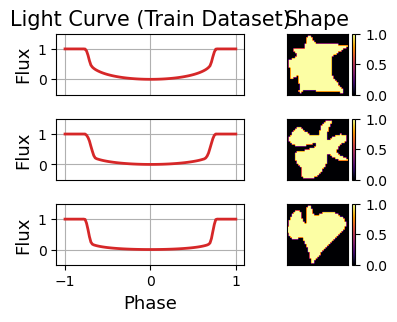

In [10]:
# Verification
# Plot - Train LCs
plt.clf()
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_horiz_scaled[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_horiz_scaled)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    # ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_horiz_scaled[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [12]:
vald_lc_horiz_scaled = scale_horizontally(vald_lc_scaled_append)

Length of one LC =  150
input_lc_dataset_interpol.shape = (1000, 120)
center_index = 75
left_index = 11
right_index = 139
left_index = 14
right_index = 136
left_index = 11
right_index = 139
left_index = 10
right_index = 140
left_index = 10
right_index = 140
left_index = 10
right_index = 140
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 18
right_index = 132
left_index = 13
right_index = 137
left_index = 19
right_index = 131
left_index = 11
right_index = 139
left_index = 14
right_index = 136
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 14
right_index = 136
left_index = 13
right_index = 137
left_index = 10
right_index = 140
left_index = 11
right_index = 139
left_index = 11
right_index = 139
left_index = 14
right_index = 136
left_index = 18
right_index = 132
left_index = 11
right_index = 139
left_index = 10
right_index 

<Figure size 640x480 with 0 Axes>

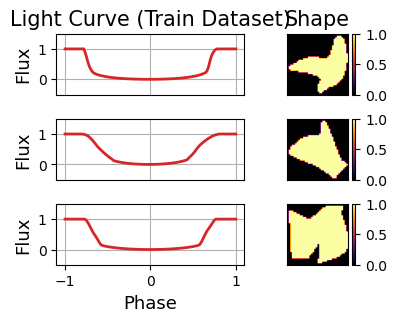

In [13]:
# Verification
# Plot - Vald LCs
plt.clf()
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_horiz_scaled[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(vald_lc_horiz_scaled)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    # ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, vald_lc_horiz_scaled[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [ ]:
# ML Pipeline
## Train Set
train_dataset = tf.data.Dataset.from_tensor_slices((train_lc_scaled_append,train_shape))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

## Vald Set
vald_dataset = tf.data.Dataset.from_tensor_slices((vald_lc_scaled_append,vald_shape))
vald_dataset = vald_dataset.batch(100)
vald_dataset = vald_dataset.cache()
vald_dataset = vald_dataset.prefetch(tf.data.AUTOTUNE)
print(vald_dataset)

# CNN Model
input_shape = np.array(np.shape(train_lc_scaled_append[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] 
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()
print("Model is defined")

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
print("Model is compiled")

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
print("Early stopping defined")

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)
print("Learning rate scheduler defined")

# Training 
print("Training will start now")
# history = model.fit(train_lc_scaled_interpol, train_shape, epochs=200,verbose=2, validation_data=(vald_lc_scaled_interpol,vald_shape),callbacks=[es,lr_sched])
no_epochs = int(200)
print("no_epochs = ",no_epochs)
history = model.fit(train_dataset, epochs=no_epochs,verbose=2, validation_data=vald_dataset,callbacks=[es,lr_sched])

# Save Model (Uncomment onlt if you are really running this)
save_model(model, "/scratch/abraham/Documents/mega_git/mega/ml_model/april9_2024_model/april9_2024_model_unfDist_LDC_size.h5")
print("Model saved")

tf.keras.backend.clear_session()
print("End of code")